# 06_experiments.ipynb — Experimentos de Resiliencia (AE Latente)

Este cuaderno implementa **5 experimentos** sobre el autoencoder (AE) y el espacio latente para evaluar **resiliencia territorial** bajo escenarios SSP.

**Experimentos**
1. Representación base (reconstrucción)
2. Clustering (KMeans / DBSCAN)
3. Sensibilidad a k (Silhouette / Davies–Bouldin)
4. Ablaciones (exclusión de variables)
5. Validación cruzada espacial


In [79]:

import os, re, pickle
import numpy as np
import pandas as pd
import xarray as xr

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, r2_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

BASE_DIR = "/home/aninotna/magister/tesis/justh2_pipeline"
DATA_DIR = os.path.join(BASE_DIR, "data/autoencoder_tensors")
MODE = "test"

PATH_SSP245 = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}.npz")
PATH_SSP370 = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}.npz")
PATH_SSP585 = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}.npz")

PATH_SSP245_ORIG = os.path.join(DATA_DIR, f"tensors_ssp245_splits_{MODE}_ORIGINAL.npz")
PATH_SSP370_ORIG = os.path.join(DATA_DIR, f"tensors_ssp370_splits_{MODE}_ORIGINAL.npz")
PATH_SSP585_ORIG = os.path.join(DATA_DIR, f"tensors_ssp585_splits_{MODE}_ORIGINAL.npz")

PATH_METADATA = os.path.join(DATA_DIR, f"metadata_{MODE}.pkl")
PATH_FEATURE_NAMES = os.path.join(DATA_DIR, f"feature_names_{MODE}.csv")

print("✓ Config cargada")


✓ Config cargada


In [80]:

def load_npz(path):
    d = np.load(path)
    X = np.vstack([d["X_train"], d["X_val"], d["X_test"]])
    idx = np.concatenate([d["train_idx"], d["val_idx"], d["test_idx"]])
    return X, idx

def load_npz_orig(path):
    d = np.load(path)
    X = np.vstack([d["X_train_original"], d["X_val_original"], d["X_test_original"]])
    idx = np.concatenate([d["train_idx"], d["val_idx"], d["test_idx"]])
    return X, idx

X245_norm, idx245 = load_npz(PATH_SSP245)
X370_norm, idx370 = load_npz(PATH_SSP370)
X585_norm, idx585 = load_npz(PATH_SSP585)

X245_orig, _ = load_npz_orig(PATH_SSP245_ORIG)
X370_orig, _ = load_npz_orig(PATH_SSP370_ORIG)
X585_orig, _ = load_npz_orig(PATH_SSP585_ORIG)

feature_names = pd.read_csv(PATH_FEATURE_NAMES)["feature_name"].tolist()

with open(PATH_METADATA, "rb") as f:
    meta = pickle.load(f)

splits = meta["splits"]
mask = meta["mask"]
lat = meta["spatial_info"]["lat"]
lon = meta["spatial_info"]["lon"]

lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
flat_lat = lat_grid[mask]
flat_lon = lon_grid[mask]
all_idx = np.concatenate([splits["train_idx"], splits["val_idx"], splits["test_idx"]])
coords_df = pd.DataFrame({
    "lat": flat_lat[all_idx],
    "lon": flat_lon[all_idx],
    "pixel_id": np.arange(flat_lat[all_idx].shape[0])
})

print("Shapes norm:", X245_norm.shape, X370_norm.shape, X585_norm.shape)
print("Coords:", coords_df.shape)


Shapes norm: (661, 293) (661, 293) (661, 293)
Coords: (661, 3)


In [81]:

DEC_BASE = [2020]
DEC_TARGET = [2040, 2060, 2080]

def cols_for_decades(names, decades):
    pat = re.compile(r"_decadal_(?:mean|max|min)_(\d{4})$")
    idx = []
    for j, n in enumerate(names):
        m = pat.search(n)
        if m and int(m.group(1)) in decades:
            idx.append(j)
    return idx

def non_decadal_idx(names):
    return [j for j, n in enumerate(names) if "_decadal_" not in n]

base_idx = cols_for_decades(feature_names, DEC_BASE)
tgt_idx  = cols_for_decades(feature_names, DEC_TARGET)
non_idx  = non_decadal_idx(feature_names)

def h2_cols(names, decades):
    pat = re.compile(r"calliope_h2_prod_ton_decadal_(?:mean|max|min)_(\d{4})$")
    idx = []
    for j, n in enumerate(names):
        m = pat.search(n)
        if m and int(m.group(1)) in decades:
            idx.append(j)
    if idx:
        return idx
    if "calliope_h2_prod_ton" in names:
        return [names.index("calliope_h2_prod_ton")]
    raise ValueError("No encontré columnas de H2.")

h2_base_idx = h2_cols(feature_names, DEC_BASE)
h2_tgt_idx  = h2_cols(feature_names, DEC_TARGET)

def take_h2(X, idxs):
    H = X[:, idxs]
    return H.mean(axis=1) if H.ndim == 2 and H.shape[1] > 1 else H.squeeze()


In [82]:

def subset_cols(X, idx_keep):
    return X[:, idx_keep]

# Base: one decade (2020) + non-decadal
B245 = np.hstack([subset_cols(X245_norm, base_idx), subset_cols(X245_norm, non_idx)])
B370 = np.hstack([subset_cols(X370_norm, base_idx), subset_cols(X370_norm, non_idx)])
B585 = np.hstack([subset_cols(X585_norm, base_idx), subset_cols(X585_norm, non_idx)])

# Target: three decades (2040, 2060, 2080) - we need to aggregate them
# to match the structure of base (single decade representation)
def aggregate_target_decades(X, tgt_idx, non_idx, n_stats_per_decade):
    """Aggregate multiple target decades into mean features to match base structure"""
    tgt_features = X[:, tgt_idx]
    non_features = X[:, non_idx]

    if n_stats_per_decade == 0:
        raise ValueError("No hay columnas decenales base disponibles para la agregación.")

    # Group by variable type (mean, max, min) and aggregate across decades
    n_decades_target = len(tgt_idx) // n_stats_per_decade  # typically 3

    if len(tgt_idx) % n_stats_per_decade != 0:
        print(f"Warning: tgt_idx length {len(tgt_idx)} not divisible by base stats {n_stats_per_decade}")
        print("Using simple averaging across target features")
        n_decades_target = max(1, n_decades_target)
        agg_features = []
        step = len(tgt_idx) // max(1, n_decades_target)
        if step == 0:
            agg_features.append(tgt_features.mean(axis=1, keepdims=True))
        else:
            for i in range(0, len(tgt_idx), step):
                chunk = tgt_features[:, i:i+step]
                agg_features.append(chunk.mean(axis=1, keepdims=True))
        tgt_agg = np.hstack(agg_features)
    else:
        tgt_reshaped = tgt_features.reshape(tgt_features.shape[0], n_stats_per_decade, n_decades_target)
        tgt_agg = tgt_reshaped.mean(axis=2)  # average across decades dimension

    return np.hstack([tgt_agg, non_features])

T245 = aggregate_target_decades(X245_norm, tgt_idx, non_idx, len(base_idx))
T370 = aggregate_target_decades(X370_norm, tgt_idx, non_idx, len(base_idx))
T585 = aggregate_target_decades(X585_norm, tgt_idx, non_idx, len(base_idx))

X_BASE = np.vstack([B245, B370, B585])

print("BASE/TARGET shapes:", X_BASE.shape, T245.shape, T370.shape, T585.shape)
print(f"  base_idx: {len(base_idx)}, tgt_idx: {len(tgt_idx)}, non_idx: {len(non_idx)}")


BASE/TARGET shapes: (1983, 37) (661, 37) (661, 37) (661, 37)
  base_idx: 24, tgt_idx: 72, non_idx: 13


In [96]:

def plot_spatial_categories(labels, title, cmap="tab10", alpha=0.75, s=20):
    labels_arr = np.asarray(labels)
    valid_mask = ~pd.isna(labels_arr)
    if not valid_mask.any():
        print(f"Sin datos válidos para {title}")
        return
    unique_vals = np.sort(np.unique(labels_arr[valid_mask]))
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    try:
        xs, ys = _get_mercator_coords()
        grid_res = _infer_grid_resolution(valid_mask.sum())
        grid_x = np.linspace(xs.min(), xs.max(), grid_res)
        grid_y = np.linspace(ys.min(), ys.max(), grid_res)
        GX, GY = np.meshgrid(grid_x, grid_y)
        coords = np.column_stack([xs[valid_mask], ys[valid_mask]])
        targets = labels_arr[valid_mask]
        cat_to_int = {val: idx for idx, val in enumerate(unique_vals)}
        int_targets = np.vectorize(cat_to_int.get)(targets)
        grid_points = np.column_stack([GX.ravel(), GY.ravel()])
        n_neighbors = max(1, min(len(int_targets), int(np.sqrt(len(int_targets)))))
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance")
        clf.fit(coords, int_targets)
        pred_int = clf.predict(grid_points).reshape(GX.shape)
        extent = (grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max())
        ax.set_xlim(extent[0], extent[1])
        ax.set_ylim(extent[2], extent[3])
        try:
            import contextily as ctx
            ctx.add_basemap(
                ax,
                source=ctx.providers.CartoDB.Positron,
                crs="EPSG:3857",
                alpha=1.0,
                attribution_size=6,
            )
        except Exception as basemap_err:
            ax.text(
                0.02,
                0.02,
                f"Basemap no disponible: {basemap_err}",
                transform=ax.transAxes,
                fontsize=8,
                color="red",
                bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
            )
        from matplotlib.colors import ListedColormap, BoundaryNorm
        from matplotlib.cm import ScalarMappable
        base_cmap = plt.get_cmap(cmap, len(unique_vals))
        discrete_cmap = ListedColormap(base_cmap(np.arange(len(unique_vals))))
        boundaries = np.arange(len(unique_vals) + 1) - 0.5
        norm = BoundaryNorm(boundaries, discrete_cmap.N)
        heat = ax.imshow(
            pred_int,
            extent=extent,
            origin="lower",
            cmap=discrete_cmap,
            norm=norm,
            alpha=alpha,
            zorder=3,
        )
        ax.set_axis_off()
        mappable = ScalarMappable(norm=norm, cmap=discrete_cmap)
        cbar = fig.colorbar(
            mappable,
            ax=ax,
            fraction=0.035,
            pad=0.02,
            ticks=np.arange(len(unique_vals)),
        )
        cbar.set_ticklabels([str(val) for val in unique_vals])
        cbar.set_label("Categoría")
        ax.set_title(title)
        fig.tight_layout()
        plt.show()
        return
    except Exception as err:
        ax.text(
            0.02,
            0.02,
            f"Heatmap categórico no disponible ({err}); usando dispersión.",
            transform=ax.transAxes,
            fontsize=8,
            color="red",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
        )
    sc = ax.scatter(
        LONS,
        LATS,
        c=labels_arr,
        cmap=plt.get_cmap(cmap, len(unique_vals)),
        s=s,
        alpha=0.9,
        edgecolor="k",
        linewidth=0.2,
    )
    ax.set_title(title)
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.set_aspect("equal", adjustable="box")
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("Categoría")
    fig.tight_layout()
    plt.show()

In [84]:

class AE(nn.Module):
    def __init__(self, input_dim, latent_dim=8, p_drop=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(64, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

@torch.no_grad()
def encode_ae(model, X):
    tensor = torch.tensor(X, dtype=torch.float32)
    return model.encoder(tensor).numpy()

@torch.no_grad()
def get_z(model, X):
    return encode_ae(model, X)

def train_ae(model, X_tr, X_val, epochs=400, lr=1e-3, batch_size=64,
             weight_decay=1e-4, noise_std=0.05, patience=30, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    Xtr = torch.tensor(X_tr, dtype=torch.float32)
    Xva = torch.tensor(X_val, dtype=torch.float32)
    best, best_val, best_epoch = None, float("inf"), -1
    wait = 0
    history = {"early_stop": False}
    train_curve, val_curve = [], []

    for ep in range(epochs):
        model.train()
        idx = torch.randperm(Xtr.size(0))
        train_loss_sum = 0.0
        n_seen = 0
        for i in range(0, Xtr.size(0), batch_size):
            batch = Xtr[idx[i:i+batch_size]]
            noisy = batch + noise_std * torch.randn_like(batch)
            opt.zero_grad()
            x_hat, _ = model(noisy)
            loss = ((x_hat - batch)**2).mean()
            loss.backward()
            opt.step()
            train_loss_sum += loss.item() * batch.size(0)
            n_seen += batch.size(0)

        avg_train = train_loss_sum / max(1, n_seen)
        train_curve.append(avg_train)

        model.eval()
        with torch.no_grad():
            xhat_val, _ = model(Xva)
            val_loss = ((xhat_val - Xva)**2).mean().item()
        val_curve.append(val_loss)

        if verbose and ep % 25 == 0:
            print(f"[AE] ep {ep:03d} | val_mse={val_loss:.6f}")
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_epoch = ep
            best = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                history["early_stop"] = True
                if verbose:
                    print(f"[AE] Early stop @ {ep} | best_val={best_val:.6f}")
                break

    if best is not None:
        model.load_state_dict(best)

    history.update({
        "val_mse": best_val,
        "epochs": ep + 1,
        "best_epoch": best_epoch,
        "train_curve": train_curve,
        "val_curve": val_curve,
    })
    return model, history

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=12, p_drop=0.1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(p_drop),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

def elbo_loss(x, x_hat, mu, logvar, beta=1.0):
    recon = F.mse_loss(x_hat, x, reduction="mean")
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + beta * kl, recon, kl

def beta_schedule(epoch, beta_max=1.0, beta_min=0.1, warmup=80):
    if epoch <= 5:
        return beta_min
    if epoch < warmup:
        frac = (epoch - 5) / max(1, warmup - 5)
        return beta_min + (beta_max - beta_min) * frac
    return beta_max

def train_vae(model, X_tr, X_val, epochs=400, lr=1e-3, batch_size=64,
              beta=1.0, warmup=80, weight_decay=1e-4, noise_std=0.05,
              patience=30, verbose=True):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    Xtr = torch.tensor(X_tr, dtype=torch.float32)
    Xva = torch.tensor(X_val, dtype=torch.float32)
    best, best_val, best_epoch = None, float("inf"), -1
    best_recon, best_kl = None, None
    wait = 0
    history = {"early_stop": False}
    train_curve, val_curve = [], []
    train_recon_curve, train_kl_curve = [], []
    val_recon_curve, val_kl_curve = [], []

    for ep in range(epochs):
        model.train()
        cur_beta = beta_schedule(ep, beta_max=beta, warmup=warmup)
        idx = torch.randperm(Xtr.size(0))
        train_loss_sum = 0.0
        train_recon_sum = 0.0
        train_kl_sum = 0.0
        n_seen = 0

        for i in range(0, Xtr.size(0), batch_size):
            batch = Xtr[idx[i:i+batch_size]]
            noisy = batch + noise_std * torch.randn_like(batch)
            opt.zero_grad()
            x_hat, mu, logvar = model(noisy)
            loss, recon, kl = elbo_loss(batch, x_hat, mu, logvar, beta=cur_beta)
            loss.backward()
            opt.step()

            batch_size_effective = batch.size(0)
            train_loss_sum += loss.item() * batch_size_effective
            train_recon_sum += recon.item() * batch_size_effective
            train_kl_sum += kl.item() * batch_size_effective
            n_seen += batch_size_effective

        avg_train = train_loss_sum / max(1, n_seen)
        avg_train_recon = train_recon_sum / max(1, n_seen)
        avg_train_kl = train_kl_sum / max(1, n_seen)
        train_curve.append(avg_train)
        train_recon_curve.append(avg_train_recon)
        train_kl_curve.append(avg_train_kl)

        model.eval()
        with torch.no_grad():
            x_hat_val, mu_val, logvar_val = model(Xva)
            val_loss, val_recon, val_kl = elbo_loss(Xva, x_hat_val, mu_val, logvar_val, beta=cur_beta)
            val_loss = val_loss.item()
            val_recon = val_recon.item()
            val_kl = val_kl.item()
        val_curve.append(val_loss)
        val_recon_curve.append(val_recon)
        val_kl_curve.append(val_kl)

        if verbose and ep % 25 == 0:
            print(
                f"[VAE] ep {ep:03d} | val={val_loss:.6f} (recon={val_recon:.6f}, "
                f"kl={val_kl:.6f}) beta={cur_beta:.3f}"
            )
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_epoch = ep
            best_recon = val_recon
            best_kl = val_kl
            best = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                history["early_stop"] = True
                if verbose:
                    print(f"[VAE] Early stop @ {ep} | best_val={best_val:.6f}")
                break

    if best is not None:
        model.load_state_dict(best)

    history.update({
        "val_loss": best_val,
        "val_recon": best_recon,
        "val_kl": best_kl,
        "epochs": ep + 1,
        "best_epoch": best_epoch,
        "train_curve": train_curve,
        "val_curve": val_curve,
        "train_recon_curve": train_recon_curve,
        "train_kl_curve": train_kl_curve,
        "val_recon_curve": val_recon_curve,
        "val_kl_curve": val_kl_curve,
    })
    return model, history

@torch.no_grad()
def encode_vae(model, X, return_logvar=False):
    tensor = torch.tensor(X, dtype=torch.float32)
    x_hat, mu, logvar = model(tensor)
    if return_logvar:
        return mu.numpy(), logvar.numpy()
    return mu.numpy()

@torch.no_grad()
def reconstruction_mse(model_key, model, X):
    tensor = torch.tensor(X, dtype=torch.float32)
    if model_key == "AE":
        x_hat, _ = model(tensor)
    elif model_key == "VAE":
        x_hat, _, _ = model(tensor)
    else:
        raise ValueError(f"Modelo no soportado: {model_key}")
    return ((x_hat - tensor)**2).mean().item()

def get_latent_vectors(model_key, model, X, return_logvar=False):
    if model_key == "AE":
        return encode_ae(model, X)
    if model_key == "VAE":
        if return_logvar:
            return encode_vae(model, X, return_logvar=True)
        return encode_vae(model, X)
    raise ValueError(f"Modelo no soportado: {model_key}")


## Experimento 1 — Representación base (reconstrucción)

In [85]:

perm = np.random.permutation(X_BASE.shape[0])
n_val = int(0.2 * len(perm))
val_idx, tr_idx = perm[:n_val], perm[n_val:]
X_tr, X_val = X_BASE[tr_idx], X_BASE[val_idx]

LATENT_DIM_AE = 8
LATENT_DIM_VAE = 8
LR = 1e-3
N_PER_SCENARIO = B245.shape[0]

MODEL_ORDER = ["AE", "VAE"]
MODEL_CONFIG = {
    "AE": {
        "latent_dim": LATENT_DIM_AE,
        "build_fn": lambda input_dim: AE(input_dim, latent_dim=LATENT_DIM_AE, p_drop=0.1),
        "train_fn": train_ae,
        "train_kwargs": {
            "epochs": 400,
            "lr": LR,
            "batch_size": 64,
            "weight_decay": 1e-4,
            "noise_std": 0.05,
            "patience": 30,
            "verbose": True,
        },
    },
    "VAE": {
        "latent_dim": LATENT_DIM_VAE,
        "build_fn": lambda input_dim: VAE(input_dim, latent_dim=LATENT_DIM_VAE, p_drop=0.1),
        "train_fn": train_vae,
        "train_kwargs": {
            "epochs": 400,
            "lr": LR,
            "batch_size": 64,
            "weight_decay": 1e-4,
            "noise_std": 0.05,
            "patience": 30,
            "verbose": True,
            "beta": 1.0,
            "warmup": 80,
        },
    },
}

MODELS = {}
MODEL_TRAIN_LOGS = {}
LATENTS = {}
LATENT_LOGVARS = {}
RECON_ROWS = []

DATA_BLOCKS = {
    "base": X_BASE,
    "B245": B245,
    "B370": B370,
    "B585": B585,
    "T245": T245,
    "T370": T370,
    "T585": T585,
}

for model_key in MODEL_ORDER:
    cfg = MODEL_CONFIG[model_key]
    model = cfg["build_fn"](X_BASE.shape[1])
    model, history = cfg["train_fn"](model, X_tr, X_val, **cfg["train_kwargs"])
    model.eval()

    MODELS[model_key] = model
    MODEL_TRAIN_LOGS[model_key] = history

    with torch.no_grad():
        Xv_t = torch.tensor(X_val, dtype=torch.float32)
        if model_key == "AE":
            xhat_val, _ = model(Xv_t)
        else:
            xhat_val, _, _ = model(Xv_t)
        val_pred = xhat_val.detach().cpu().numpy()
    val_mse = reconstruction_mse(model_key, model, X_val)
    val_r2 = r2_score(X_val, val_pred, multioutput="variance_weighted")
    MODEL_TRAIN_LOGS[model_key]["val_r2"] = val_r2

    row = {
        "model": model_key,
        "latent_dim": cfg["latent_dim"],
        "val_mse": val_mse,
        "val_r2": val_r2,
        "epochs_trained": history.get("epochs"),
        "best_epoch": history.get("best_epoch"),
        "early_stop": history.get("early_stop"),
    }
    if model_key == "VAE":
        row.update({
            "val_elbo": history.get("val_loss"),
            "val_recon_component": history.get("val_recon"),
            "val_kl_component": history.get("val_kl"),
        })

    latents = {}
    logvars = {}
    for label, data in DATA_BLOCKS.items():
        if model_key == "VAE":
            mu, logvar = get_latent_vectors(model_key, model, data, return_logvar=True)
            latents[label] = mu
            logvars[label] = logvar
        else:
            latents[label] = get_latent_vectors(model_key, model, data)
    LATENTS[model_key] = latents
    if logvars:
        LATENT_LOGVARS[model_key] = logvars

    RECON_ROWS.append(row)

recon_df = pd.DataFrame(RECON_ROWS)
print("Reconstrucción (validación) por modelo:")
print(recon_df)

for model_key in MODEL_ORDER:
    base_lat_shape = LATENTS[model_key]["base"].shape
    print(f"  {model_key}: latent base shape={base_lat_shape}")


[AE] ep 000 | val_mse=0.783940
[AE] ep 025 | val_mse=0.057754
[AE] ep 025 | val_mse=0.057754
[AE] ep 050 | val_mse=0.037640
[AE] ep 050 | val_mse=0.037640
[AE] ep 075 | val_mse=0.033265
[AE] ep 075 | val_mse=0.033265
[AE] ep 100 | val_mse=0.028296
[AE] ep 100 | val_mse=0.028296
[AE] ep 125 | val_mse=0.027965
[AE] ep 125 | val_mse=0.027965
[AE] ep 150 | val_mse=0.026780
[AE] ep 150 | val_mse=0.026780
[AE] ep 175 | val_mse=0.027839
[AE] ep 175 | val_mse=0.027839
[AE] ep 200 | val_mse=0.023249
[AE] ep 200 | val_mse=0.023249
[AE] ep 225 | val_mse=0.021758
[AE] ep 225 | val_mse=0.021758
[AE] ep 250 | val_mse=0.021574
[AE] ep 250 | val_mse=0.021574
[AE] ep 275 | val_mse=0.021962
[AE] Early stop @ 278 | best_val=0.020973
[AE] ep 275 | val_mse=0.021962
[AE] Early stop @ 278 | best_val=0.020973
[VAE] ep 000 | val=1.073086 (recon=1.013214, kl=0.598713) beta=0.100
[VAE] ep 000 | val=1.073086 (recon=1.013214, kl=0.598713) beta=0.100
[VAE] ep 025 | val=0.384153 (recon=0.178054, kl=0.606173) beta=0.


Curvas de entrenamiento — AE (primeros 5 epochs):
   epoch  train_loss  val_loss
0      1    1.814800  0.783940
1      2    0.590069  0.375005
2      3    0.374222  0.270873
3      4    0.300941  0.237963
4      5    0.270855  0.209907

Curvas de entrenamiento — AE (últimos 5 epochs):
     epoch  train_loss  val_loss
274    275    0.039979  0.021956
275    276    0.037982  0.021962
276    277    0.038949  0.021349
277    278    0.037117  0.021001
278    279    0.037784  0.021664

Curvas de entrenamiento — VAE (primeros 5 epochs):
   epoch  train_loss  val_loss  train_recon  train_kl  val_recon    val_kl
0      1    1.635024  1.073086     1.606185  0.288393   1.013214  0.598713
1      2    0.988032  0.709599     0.928509  0.595228   0.628394  0.812048
2      3    0.654906  0.549021     0.570127  0.847790   0.443652  1.053689
3      4    0.565715  0.463796     0.470609  0.951058   0.364009  0.997863
4      5    0.475230  0.435196     0.375051  1.001785   0.334327  1.008694

Curvas de en

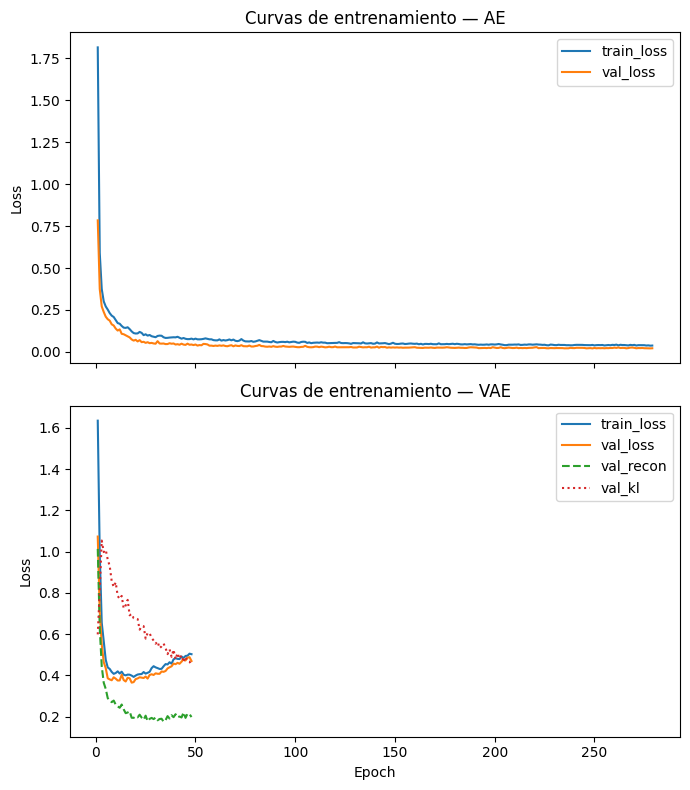

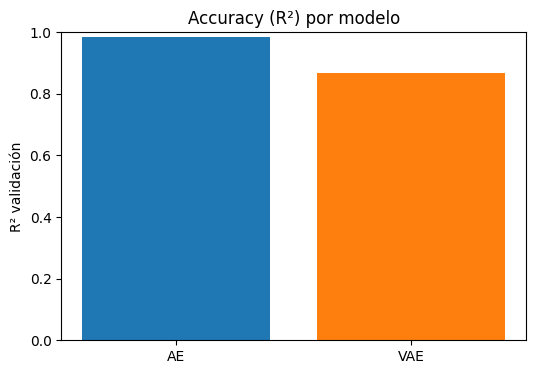

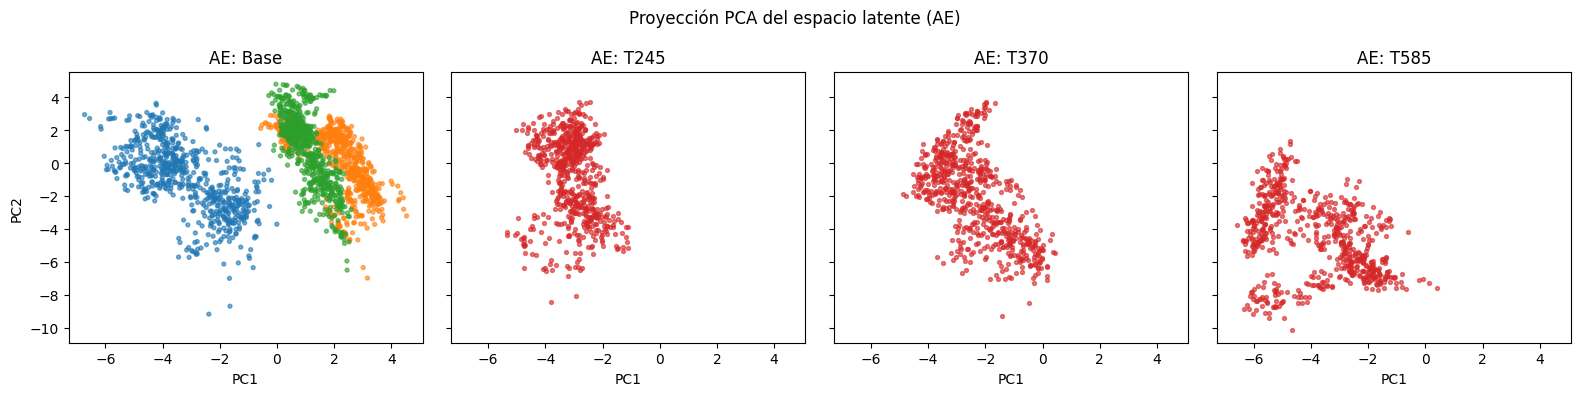

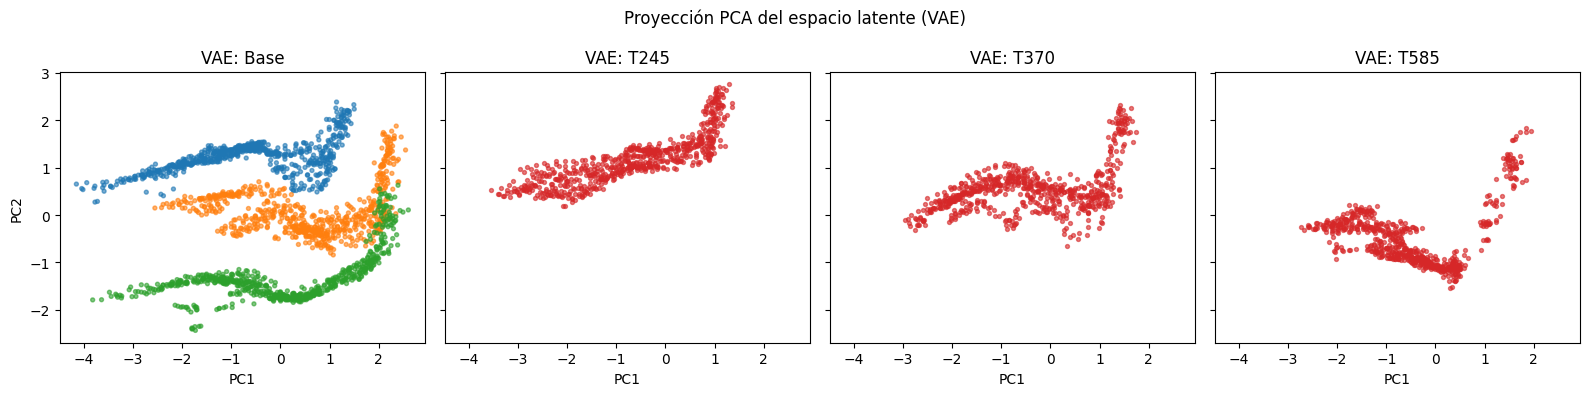

In [86]:
curve_tables = {}
for model_key in MODEL_ORDER:
    hist = MODEL_TRAIN_LOGS[model_key]
    train_curve = hist.get("train_curve", [])
    val_curve = hist.get("val_curve", [])
    epochs_hist = np.arange(1, len(train_curve) + 1)
    data = {
        "epoch": epochs_hist,
        "train_loss": train_curve,
        "val_loss": val_curve,
    }
    if model_key == "VAE":
        data.update({
            "train_recon": hist.get("train_recon_curve", []),
            "train_kl": hist.get("train_kl_curve", []),
            "val_recon": hist.get("val_recon_curve", []),
            "val_kl": hist.get("val_kl_curve", []),
        })
    df_curve = pd.DataFrame(data)
    curve_tables[model_key] = df_curve
    print(f"\nCurvas de entrenamiento — {model_key} (primeros 5 epochs):")
    print(df_curve.head())
    print(f"\nCurvas de entrenamiento — {model_key} (últimos 5 epochs):")
    print(df_curve.tail())

fig, axes = plt.subplots(len(MODEL_ORDER), 1, figsize=(7, 4 * len(MODEL_ORDER)), sharex=True)
if len(MODEL_ORDER) == 1:
    axes = [axes]
for ax, model_key in zip(axes, MODEL_ORDER):
    df_curve = curve_tables[model_key]
    ax.plot(df_curve["epoch"], df_curve["train_loss"], label="train_loss")
    ax.plot(df_curve["epoch"], df_curve["val_loss"], label="val_loss")
    if model_key == "VAE":
        ax.plot(df_curve["epoch"], df_curve.get("val_recon"), label="val_recon", linestyle="--")
        ax.plot(df_curve["epoch"], df_curve.get("val_kl"), label="val_kl", linestyle=":")
    ax.set_title(f"Curvas de entrenamiento — {model_key}")
    ax.set_ylabel("Loss")
    ax.legend()
axes[-1].set_xlabel("Epoch")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(recon_df["model"], recon_df["val_r2"], color=["tab:blue", "tab:orange"][:len(MODEL_ORDER)])
plt.ylabel("R² validación")
plt.title("Accuracy (R²) por modelo")
plt.ylim(0, 1)
plt.show()

scenario_labels = (
    ["B245"] * N_PER_SCENARIO
    + ["B370"] * N_PER_SCENARIO
    + ["B585"] * N_PER_SCENARIO
 )
color_map = {"B245": "tab:blue", "B370": "tab:orange", "B585": "tab:green"}
future_labels = ["T245", "T370", "T585"]

for model_key in MODEL_ORDER:
    z_base = LATENTS[model_key]["base"]
    pca = PCA(n_components=2, random_state=SEED)
    z_base_2d = pca.fit_transform(z_base)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
    axes[0].scatter(
        z_base_2d[:, 0],
        z_base_2d[:, 1],
        c=[color_map[label] for label in scenario_labels],
        s=8,
        alpha=0.6,
    )
    axes[0].set_title(f"{model_key}: Base")
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")
    for ax, future in zip(axes[1:], future_labels):
        z_future = LATENTS[model_key][future]
        z_future_2d = pca.transform(z_future)
        ax.scatter(
            z_future_2d[:, 0],
            z_future_2d[:, 1],
            c="tab:red",
            s=8,
            alpha=0.6,
        )
        ax.set_title(f"{model_key}: {future}")
        ax.set_xlabel("PC1")
    plt.suptitle(f"Proyección PCA del espacio latente ({model_key})")
    plt.tight_layout()
    plt.show()


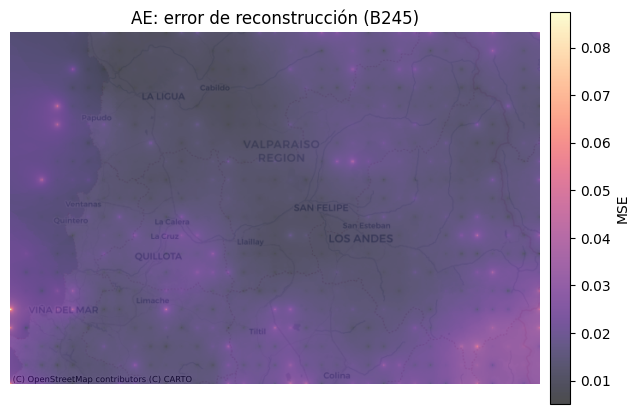

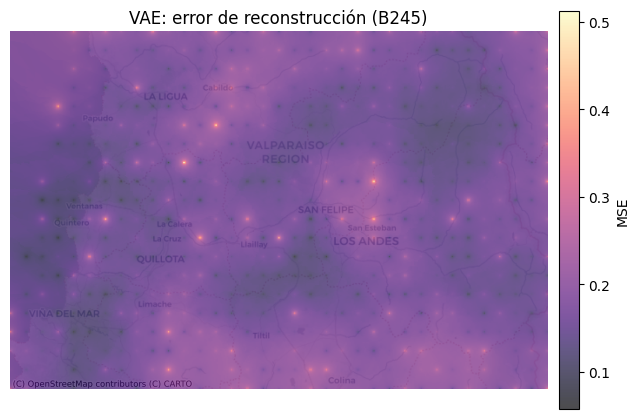

In [87]:

SPATIAL_RECON_ERRORS = {}
for model_key in MODEL_ORDER:
    model = MODELS[model_key]
    with torch.no_grad():
        X_tensor = torch.tensor(B245, dtype=torch.float32)
        if model_key == "AE":
            x_hat, _ = model(X_tensor)
        else:
            x_hat, _, _ = model(X_tensor)
    per_sample_mse = ((x_hat - X_tensor)**2).mean(dim=1).cpu().numpy()
    SPATIAL_RECON_ERRORS[model_key] = per_sample_mse
    plot_spatial_scalar(
        per_sample_mse,
        title=f"{model_key}: error de reconstrucción (B245)",
        cmap="magma",
        colorbar_label="MSE",
    )

## Experimento 2 — Clustering en espacio latente

Métricas de clustering por modelo:
  model  kmeans_k  kmeans_silhouette  kmeans_davies_bouldin  kmeans_inertia  \
0    AE         6           0.276742               1.380126    14817.236328   
1   VAE         6           0.360093               1.015467     3283.002930   

   dbscan_silhouette  dbscan_davies_bouldin  dbscan_clusters  
0            0.41886               0.825451               21  
1                NaN                    NaN                3  


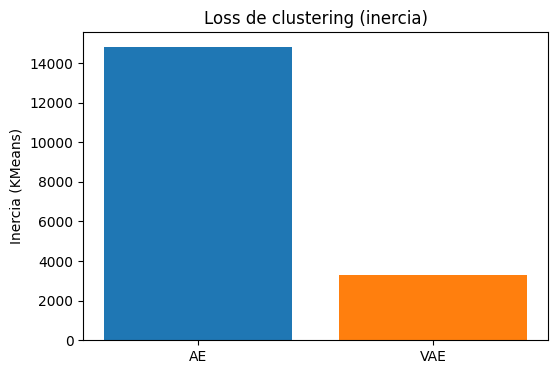

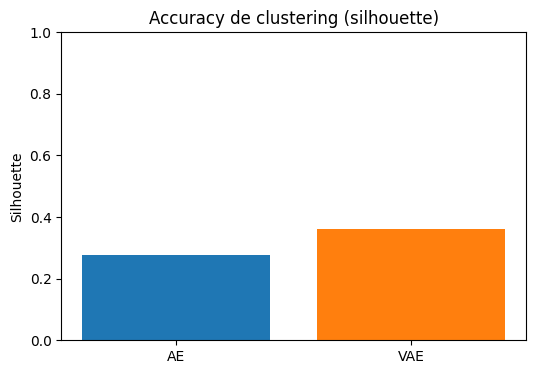

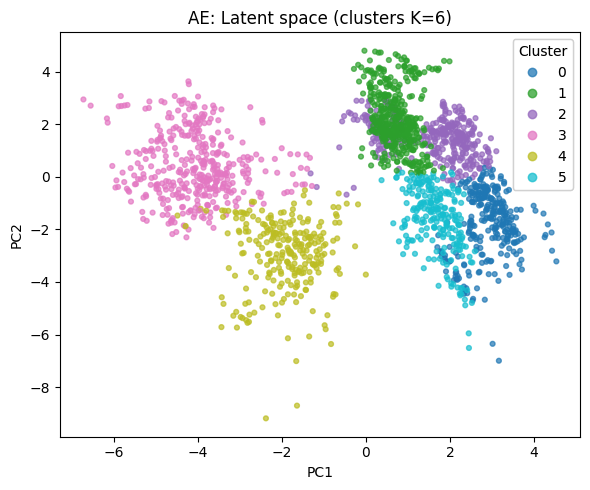

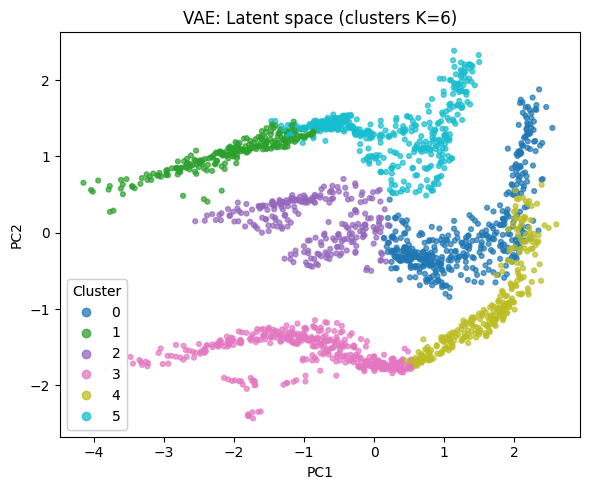

In [88]:

K_DEFAULT = 6
CLUSTER_ASSIGNMENTS = {}
CLUSTER_MODELS = {}
CLUSTERING_ROWS = []

for model_key in MODEL_ORDER:
    z_base = LATENTS[model_key]["base"]
    km = KMeans(n_clusters=K_DEFAULT, n_init=10, random_state=SEED).fit(z_base)
    labels_base = km.labels_
    sil_km = silhouette_score(z_base, labels_base)
    db_km = davies_bouldin_score(z_base, labels_base)
    inertia_km = km.inertia_

    dbscan = DBSCAN(eps=0.8, min_samples=10).fit(z_base)
    labels_db = dbscan.labels_
    if len(set(labels_db)) > 1 and (-1 in labels_db) and len(set(labels_db)) > 2:
        mask = labels_db != -1
        sil_db = silhouette_score(z_base[mask], labels_db[mask])
        db_db = davies_bouldin_score(z_base[mask], labels_db[mask])
    else:
        sil_db, db_db = np.nan, np.nan

    cluster_counts = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    CLUSTER_MODELS[model_key] = km
    CLUSTER_ASSIGNMENTS[model_key] = {
        scenario: km.predict(LATENTS[model_key][scenario])
        for scenario in ["B245", "B370", "B585", "T245", "T370", "T585"]
    }

    CLUSTERING_ROWS.append({
        "model": model_key,
        "kmeans_k": K_DEFAULT,
        "kmeans_silhouette": sil_km,
        "kmeans_davies_bouldin": db_km,
        "kmeans_inertia": inertia_km,
        "dbscan_silhouette": sil_db,
        "dbscan_davies_bouldin": db_db,
        "dbscan_clusters": cluster_counts,
    })

clustering_df = pd.DataFrame(CLUSTERING_ROWS)
print("Métricas de clustering por modelo:")
print(clustering_df)

plt.figure(figsize=(6, 4))
plt.bar(clustering_df["model"], clustering_df["kmeans_inertia"], color=["tab:blue", "tab:orange"][:len(MODEL_ORDER)])
plt.ylabel("Inercia (KMeans)")
plt.title("Loss de clustering (inercia)")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(clustering_df["model"], clustering_df["kmeans_silhouette"], color=["tab:blue", "tab:orange"][:len(MODEL_ORDER)])
plt.ylabel("Silhouette")
plt.title("Accuracy de clustering (silhouette)")
plt.ylim(0, 1)
plt.show()

for model_key in MODEL_ORDER:
    z_full = np.vstack([
        LATENTS[model_key]["B245"],
        LATENTS[model_key]["B370"],
        LATENTS[model_key]["B585"],
    ])
    labels_full = np.concatenate([
        CLUSTER_ASSIGNMENTS[model_key]["B245"],
        CLUSTER_ASSIGNMENTS[model_key]["B370"],
        CLUSTER_ASSIGNMENTS[model_key]["B585"],
    ])
    pca = PCA(n_components=2, random_state=SEED)
    z_full_2d = pca.fit_transform(z_full)
    fig, ax = plt.subplots(figsize=(6, 5))
    scatter = ax.scatter(
        z_full_2d[:, 0],
        z_full_2d[:, 1],
        c=labels_full,
        cmap="tab10",
        s=12,
        alpha=0.7,
    )
    ax.set_title(f"{model_key}: Latent space (clusters K={K_DEFAULT})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend1)
    plt.tight_layout()
    plt.show()


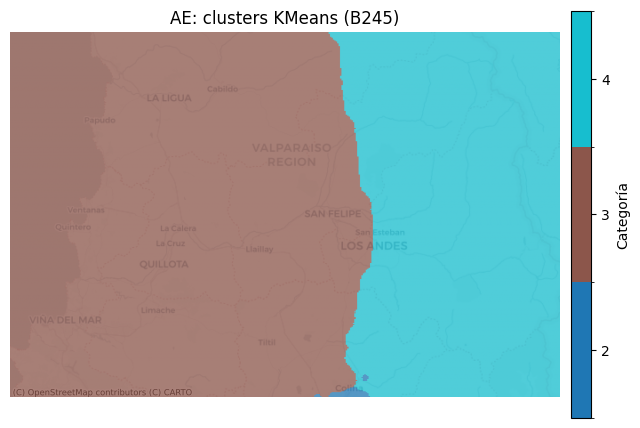

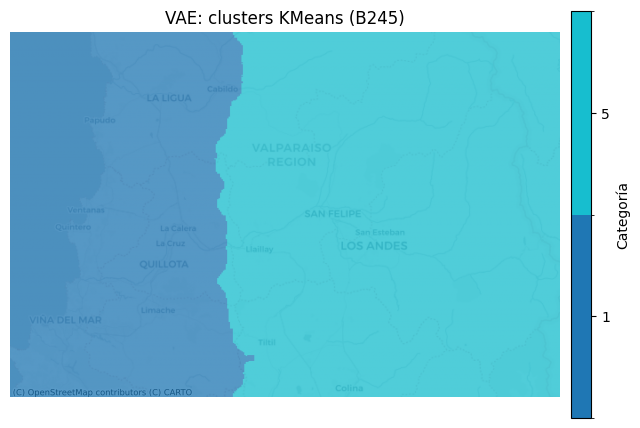

In [89]:

for model_key in MODEL_ORDER:
    labels_b245 = CLUSTER_ASSIGNMENTS[model_key]["B245"]
    plot_spatial_categories(
        labels_b245,
        title=f"{model_key}: clusters KMeans (B245)",
    )

## Experimento 3 — Sensibilidad a k


Sensibilidad a k — AE:
   k  silhouette  davies_bouldin       inertia
0  3    0.251885        1.424259  21746.169922
1  4    0.272396        1.430451  18606.728516
2  5    0.269415        1.370680  16229.634766
3  6    0.276742        1.380126  14817.236328
4  7    0.264369        1.404359  13734.782227
5  8    0.262652        1.329597  12886.496094

Sensibilidad a k — VAE:
   k  silhouette  davies_bouldin      inertia
0  3    0.292737        1.280938  5860.238281
1  4    0.316771        1.155460  4696.196777
2  5    0.344506        1.094495  3892.003418
3  6    0.360093        1.015467  3283.002686
4  7    0.387459        0.921836  2714.651367
5  8    0.388185        0.954457  2399.245850

Sensibilidad a k — VAE:
   k  silhouette  davies_bouldin      inertia
0  3    0.292737        1.280938  5860.238281
1  4    0.316771        1.155460  4696.196777
2  5    0.344506        1.094495  3892.003418
3  6    0.360093        1.015467  3283.002686
4  7    0.387459        0.921836  2714.651367

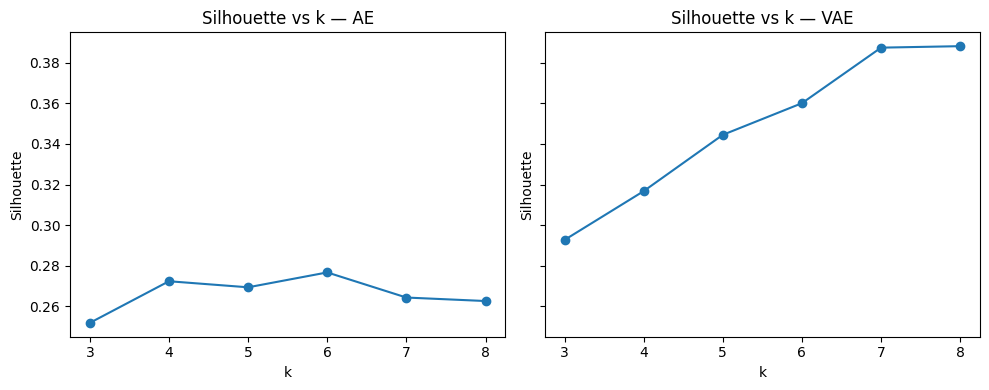

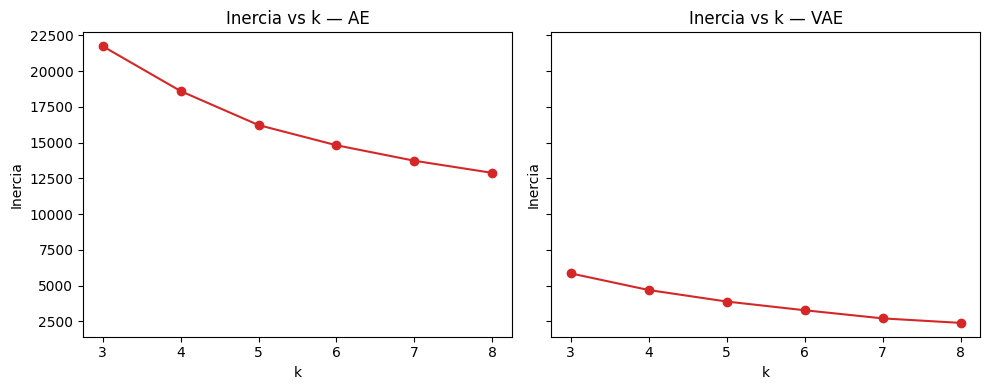

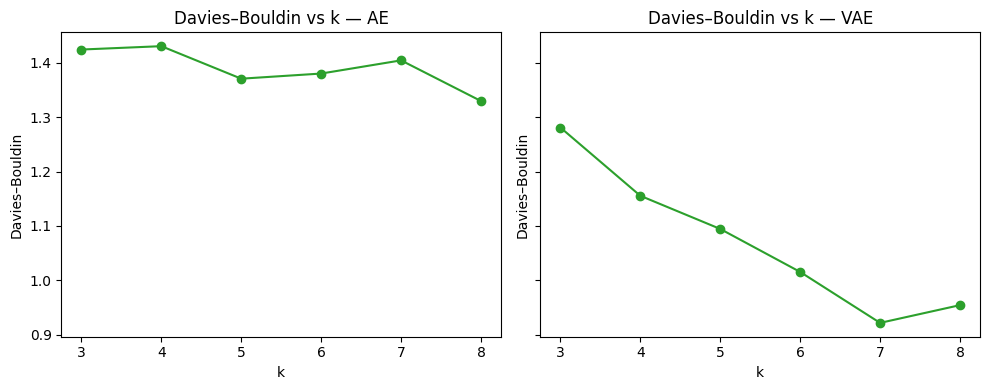

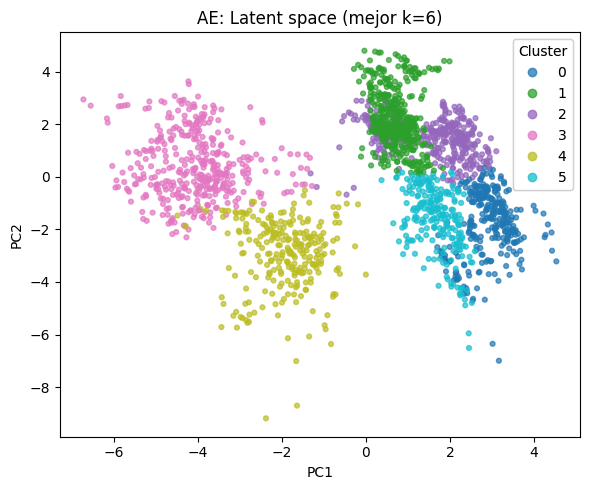

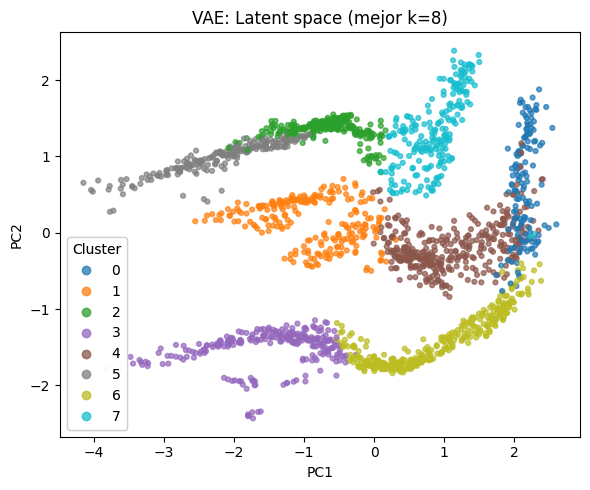

In [90]:

K_LIST = [3, 4, 5, 6, 7, 8]
K_SELECTION = {}
BEST_K = {}
BEST_K_MODELS = {}
BEST_K_ASSIGNMENTS = {}

for model_key in MODEL_ORDER:
    rows = []
    z_base = LATENTS[model_key]["base"]
    for k in K_LIST:
        kmk = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(z_base)
        lab = kmk.labels_
        sil = silhouette_score(z_base, lab)
        dbs = davies_bouldin_score(z_base, lab)
        inertia = kmk.inertia_
        rows.append((k, sil, dbs, inertia))

    kdf = pd.DataFrame(rows, columns=["k", "silhouette", "davies_bouldin", "inertia"])
    K_SELECTION[model_key] = kdf
    best_row = kdf.sort_values("silhouette", ascending=False).iloc[0]
    BEST_K[model_key] = int(best_row["k"])
    BEST_K_MODELS[model_key] = KMeans(n_clusters=BEST_K[model_key], n_init=10, random_state=SEED).fit(z_base)
    BEST_K_ASSIGNMENTS[model_key] = BEST_K_MODELS[model_key].labels_
    print(f"\nSensibilidad a k — {model_key}:")
    print(kdf)

fig, axes = plt.subplots(1, len(MODEL_ORDER), figsize=(5 * len(MODEL_ORDER), 4), sharey=True)
if len(MODEL_ORDER) == 1:
    axes = [axes]
for ax, model_key in zip(axes, MODEL_ORDER):
    kdf = K_SELECTION[model_key]
    ax.plot(kdf["k"], kdf["silhouette"], marker="o")
    ax.set_title(f"Silhouette vs k — {model_key}")
    ax.set_xlabel("k")
    ax.set_ylabel("Silhouette")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(MODEL_ORDER), figsize=(5 * len(MODEL_ORDER), 4), sharey=True)
if len(MODEL_ORDER) == 1:
    axes = [axes]
for ax, model_key in zip(axes, MODEL_ORDER):
    kdf = K_SELECTION[model_key]
    ax.plot(kdf["k"], kdf["inertia"], marker="o", color="tab:red")
    ax.set_title(f"Inercia vs k — {model_key}")
    ax.set_xlabel("k")
    ax.set_ylabel("Inercia")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, len(MODEL_ORDER), figsize=(5 * len(MODEL_ORDER), 4), sharey=True)
if len(MODEL_ORDER) == 1:
    axes = [axes]
for ax, model_key in zip(axes, MODEL_ORDER):
    kdf = K_SELECTION[model_key]
    ax.plot(kdf["k"], kdf["davies_bouldin"], marker="o", color="tab:green")
    ax.set_title(f"Davies–Bouldin vs k — {model_key}")
    ax.set_xlabel("k")
    ax.set_ylabel("Davies–Bouldin")
plt.tight_layout()
plt.show()

for model_key in MODEL_ORDER:
    z_base = LATENTS[model_key]["base"]
    labels = BEST_K_ASSIGNMENTS[model_key]
    pca = PCA(n_components=2, random_state=SEED)
    z2 = pca.fit_transform(z_base)
    fig, ax = plt.subplots(figsize=(6, 5))
    scatter = ax.scatter(z2[:, 0], z2[:, 1], c=labels, cmap="tab10", s=12, alpha=0.7)
    ax.set_title(f"{model_key}: Latent space (mejor k={BEST_K[model_key]})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
    ax.add_artist(legend1)
    plt.tight_layout()
    plt.show()


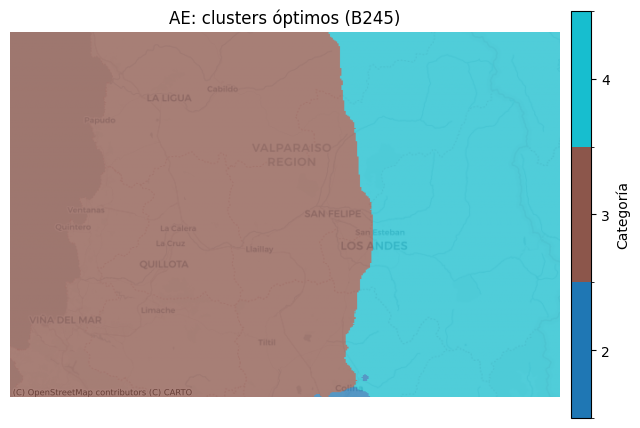

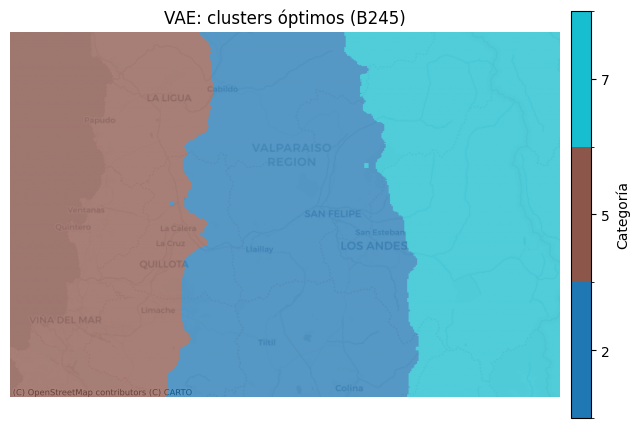

In [91]:

for model_key in MODEL_ORDER:
    km_model = BEST_K_MODELS[model_key]
    labels_opt = km_model.predict(LATENTS[model_key]["B245"])
    plot_spatial_categories(
        labels_opt,
        title=f"{model_key}: clusters óptimos (B245)",
    )

## Experimento 4 — Ablaciones (exclusión de grupos de variables)

[AE] ep 000 | val_mse=0.429633
[AE] ep 025 | val_mse=0.022680
[AE] ep 025 | val_mse=0.022680
[AE] ep 050 | val_mse=0.014826
[AE] ep 050 | val_mse=0.014826
[AE] ep 075 | val_mse=0.013146
[AE] ep 075 | val_mse=0.013146
[AE] ep 100 | val_mse=0.011476
[AE] ep 100 | val_mse=0.011476
[AE] ep 125 | val_mse=0.011522
[AE] ep 125 | val_mse=0.011522
[AE] ep 150 | val_mse=0.008367
[AE] Early stop @ 158 | best_val=0.008254
[AE] ep 150 | val_mse=0.008367
[AE] Early stop @ 158 | best_val=0.008254
[VAE] ep 000 | val=0.588066 (recon=0.530725, kl=0.573411) beta=0.100
[VAE] ep 000 | val=0.588066 (recon=0.530725, kl=0.573411) beta=0.100
[VAE] ep 025 | val=0.300481 (recon=0.145922, kl=0.454587) beta=0.340
[VAE] ep 025 | val=0.300481 (recon=0.145922, kl=0.454587) beta=0.340
[VAE] Early stop @ 42 | best_val=0.235886
[AE] ep 000 | val_mse=0.895854
[VAE] Early stop @ 42 | best_val=0.235886
[AE] ep 000 | val_mse=0.895854
[AE] ep 025 | val_mse=0.054128
[AE] ep 025 | val_mse=0.054128
[AE] ep 050 | val_mse=0.04589

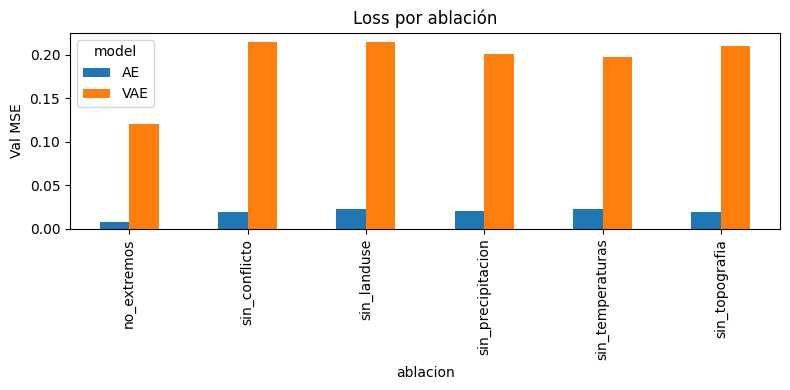

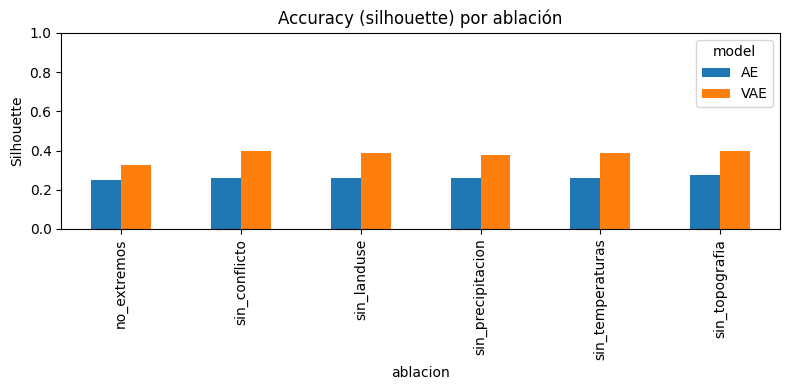

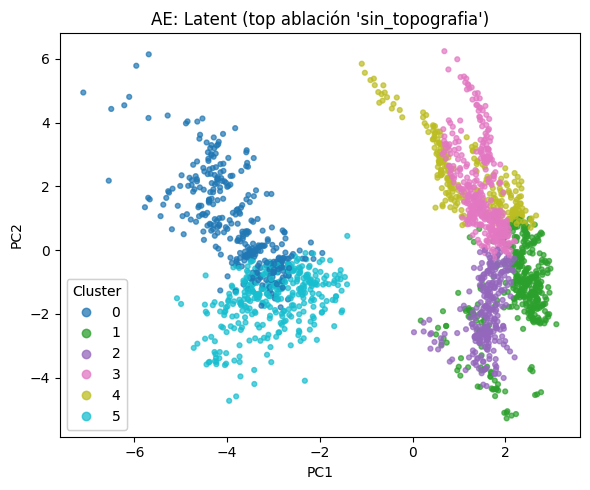

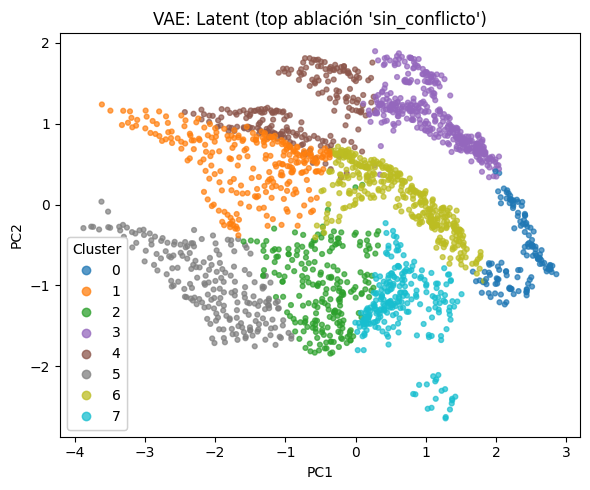

In [92]:

GROUPS = {
    "no_extremos": ["r10mm", "rx1day", "rx5day", "cdd", "sdii"],
    "sin_precipitacion": ["prcptot"],
    "sin_temperaturas": ["climate_tmax_mean", "climate_tmin_mean"],
    "sin_topografia": ["topo_elevation", "topo_slope"],
    "sin_landuse": ["landuse_suitable_pv", "landuse_restricted", "landuse_agriculture", "landuse_urban_infra", "landuse_water_glacier"],
    "sin_conflicto": ["conflict_density", "conflict_proximity"],
}

def idx_without_groups(names, groups):
    drop = set()
    for g in groups:
        for j, n in enumerate(names):
            if any(key in n for key in GROUPS[g]):
                drop.add(j)
    return [j for j in range(len(names)) if j not in drop]

ABLATION_RESULTS = []
ABLATION_LATENTS = {}
ABLATION_CLUSTER_ASSIGNMENTS = {}

for g_name in GROUPS.keys():
    keep_idx = idx_without_groups(feature_names, [g_name])
    feat_keep = [feature_names[j] for j in keep_idx]

    base_idx_subset = cols_for_decades(feat_keep, DEC_BASE)
    tgt_idx_subset = cols_for_decades(feat_keep, DEC_TARGET)
    non_idx_subset = non_decadal_idx(feat_keep)

    if len(base_idx_subset) == 0 or len(tgt_idx_subset) == 0:
        print(f"Ablación '{g_name}' sin suficientes columnas decenales; se omite.")
        continue

    X245_g = X245_norm[:, keep_idx]
    X370_g = X370_norm[:, keep_idx]
    X585_g = X585_norm[:, keep_idx]

    B245_g = np.hstack([X245_g[:, base_idx_subset], X245_g[:, non_idx_subset]])
    B370_g = np.hstack([X370_g[:, base_idx_subset], X370_g[:, non_idx_subset]])
    B585_g = np.hstack([X585_g[:, base_idx_subset], X585_g[:, non_idx_subset]])

    T245_g = aggregate_target_decades(X245_g, tgt_idx_subset, non_idx_subset, len(base_idx_subset))
    T370_g = aggregate_target_decades(X370_g, tgt_idx_subset, non_idx_subset, len(base_idx_subset))
    T585_g = aggregate_target_decades(X585_g, tgt_idx_subset, non_idx_subset, len(base_idx_subset))

    X_BASE_g = np.vstack([B245_g, B370_g, B585_g])

    perm = np.random.permutation(X_BASE_g.shape[0])
    n_val = int(0.2 * len(perm))
    val_idx = perm[:n_val]
    tr_idx = perm[n_val:]
    X_tr_g, X_val_g = X_BASE_g[tr_idx], X_BASE_g[val_idx]

    for model_key in MODEL_ORDER:
        cfg = MODEL_CONFIG[model_key]
        model = cfg["build_fn"](X_BASE_g.shape[1])
        model, history = cfg["train_fn"](model, X_tr_g, X_val_g, **cfg["train_kwargs"])
        model.eval()

        z_base_g = get_latent_vectors(model_key, model, X_BASE_g)
        k_use = BEST_K.get(model_key, K_DEFAULT)
        kmg = KMeans(n_clusters=k_use, n_init=10, random_state=SEED).fit(z_base_g)
        sil = silhouette_score(z_base_g, kmg.labels_)
        dbs = davies_bouldin_score(z_base_g, kmg.labels_)
        val_mse = reconstruction_mse(model_key, model, X_val_g)

        ABLATION_RESULTS.append({
            "ablacion": g_name,
            "model": model_key,
            "latent_dim": cfg["latent_dim"],
            "k_used": k_use,
            "silhouette": sil,
            "davies_bouldin": dbs,
            "val_mse": val_mse,
            "epochs": history.get("epochs"),
        })

        ABLATION_LATENTS[(g_name, model_key)] = z_base_g
        ABLATION_CLUSTER_ASSIGNMENTS[(g_name, model_key)] = kmg.labels_

abl_df = pd.DataFrame(ABLATION_RESULTS)
print("Resultados de ablaciones por modelo:")
print(abl_df)

if not abl_df.empty:
    loss_pivot = abl_df.pivot(index="ablacion", columns="model", values="val_mse")
    loss_pivot.plot(kind="bar", figsize=(8, 4))
    plt.ylabel("Val MSE")
    plt.title("Loss por ablación")
    plt.tight_layout()
    plt.show()

    acc_pivot = abl_df.pivot(index="ablacion", columns="model", values="silhouette")
    acc_pivot.plot(kind="bar", figsize=(8, 4))
    plt.ylabel("Silhouette")
    plt.title("Accuracy (silhouette) por ablación")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    for model_key in MODEL_ORDER:
        model_rows = abl_df[abl_df["model"] == model_key]
        if model_rows.empty:
            continue
        best_row = model_rows.sort_values("silhouette", ascending=False).iloc[0]
        key = (best_row["ablacion"], model_key)
        z_lat = ABLATION_LATENTS[key]
        labels = ABLATION_CLUSTER_ASSIGNMENTS[key]
        pca = PCA(n_components=2, random_state=SEED)
        z2 = pca.fit_transform(z_lat)
        fig, ax = plt.subplots(figsize=(6, 5))
        scatter = ax.scatter(z2[:, 0], z2[:, 1], c=labels, cmap="tab10", s=12, alpha=0.7)
        ax.set_title(
            f"{model_key}: Latent (top ablación '{best_row['ablacion']}')"
        )
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
        ax.add_artist(legend1)
        plt.tight_layout()
        plt.show()


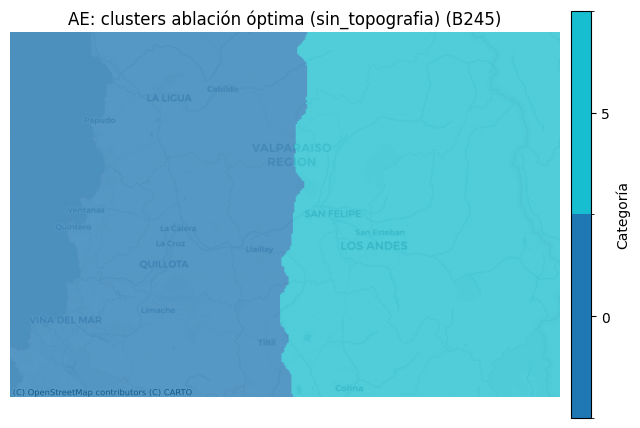

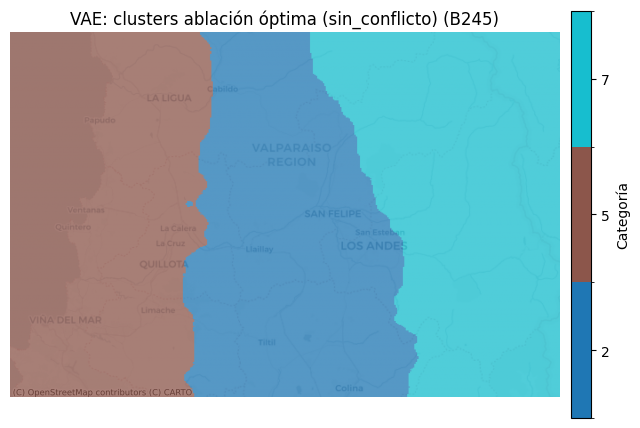

In [93]:

if not abl_df.empty:
    for model_key in MODEL_ORDER:
        subset = abl_df[abl_df["model"] == model_key]
        if subset.empty:
            continue
        best_row = subset.sort_values("silhouette", ascending=False).iloc[0]
        key = (best_row["ablacion"], model_key)
        labels_full = ABLATION_CLUSTER_ASSIGNMENTS[key]
        labels_b245 = labels_full[get_scenario_slice("B245")]
        plot_spatial_categories(
            labels_b245,
            title=f"{model_key}: clusters ablación óptima ({best_row['ablacion']}) (B245)",
        )
else:
    print("Sin resultados de ablación para mapear.")

## Experimento 5 — Validación cruzada espacial

Folds espaciales base: [0 1 2 3]
fold_ids shape: (1983,), X_BASE shape: (1983, 37)
[AE] ep 000 | val_mse=1.309270
[AE] ep 025 | val_mse=0.257713
[AE] ep 025 | val_mse=0.257713
[AE] ep 050 | val_mse=0.225997
[AE] ep 050 | val_mse=0.225997
[AE] ep 075 | val_mse=0.189804
[AE] ep 075 | val_mse=0.189804
[AE] ep 100 | val_mse=0.168664
[AE] ep 100 | val_mse=0.168664
[AE] ep 125 | val_mse=0.143680
[AE] ep 125 | val_mse=0.143680
[AE] ep 150 | val_mse=0.153370
[AE] Early stop @ 154 | best_val=0.134865
[AE] ep 000 | val_mse=0.879290
[AE] ep 150 | val_mse=0.153370
[AE] Early stop @ 154 | best_val=0.134865
[AE] ep 000 | val_mse=0.879290
[AE] ep 025 | val_mse=0.129505
[AE] ep 025 | val_mse=0.129505
[AE] ep 050 | val_mse=0.101867
[AE] ep 050 | val_mse=0.101867
[AE] ep 075 | val_mse=0.092913
[AE] ep 075 | val_mse=0.092913
[AE] ep 100 | val_mse=0.101157
[AE] ep 100 | val_mse=0.101157
[AE] ep 125 | val_mse=0.083242
[AE] ep 125 | val_mse=0.083242
[AE] ep 150 | val_mse=0.084958
[AE] ep 150 | val_mse=0.084

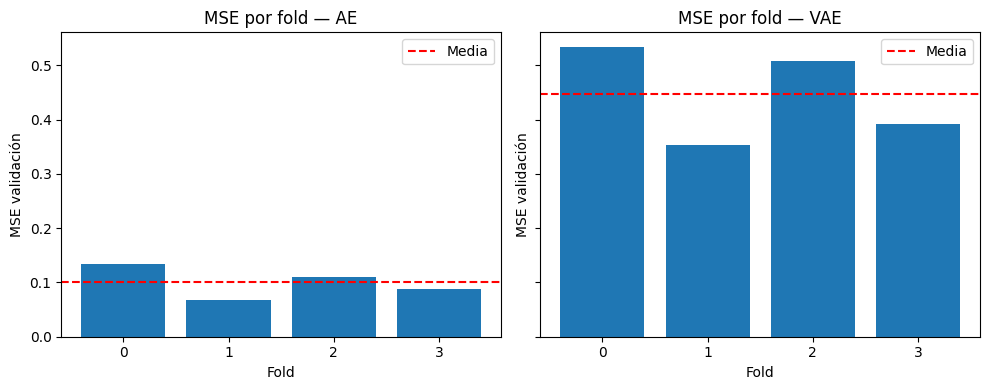

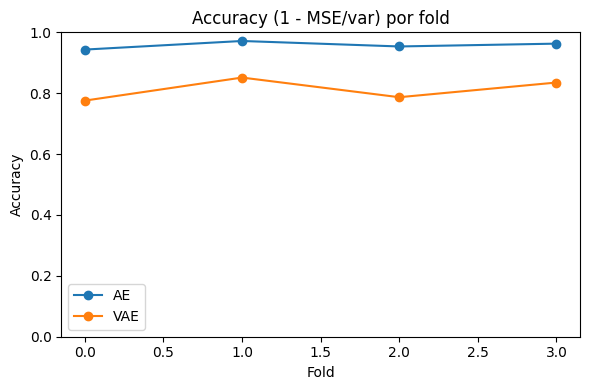

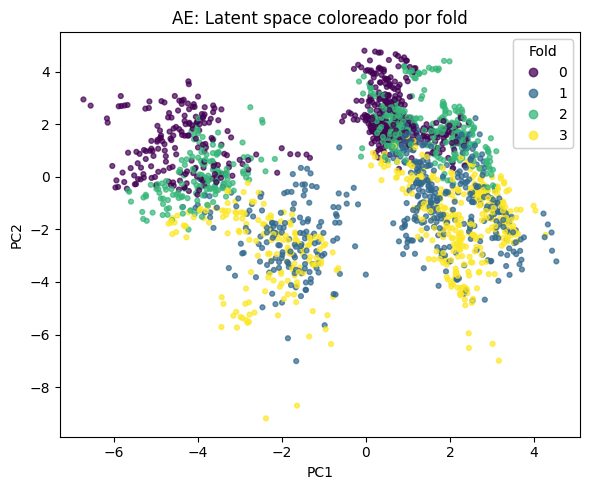

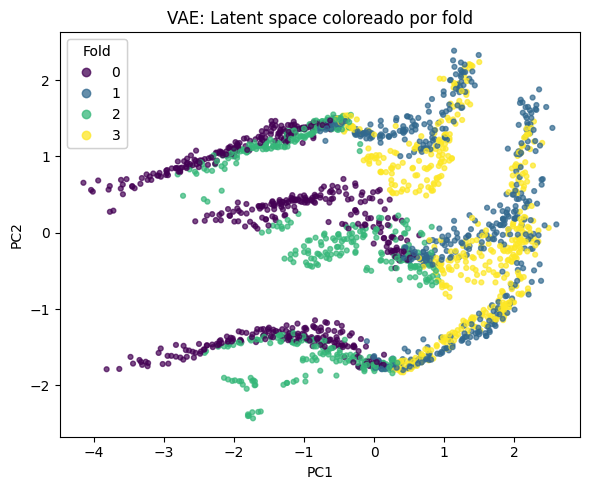

In [94]:

def spatial_folds(coords, n_lat_bins=2, n_lon_bins=2):
    lat_bins = pd.qcut(coords["lat"], q=n_lat_bins, labels=False, duplicates="drop")
    lon_bins = pd.qcut(coords["lon"], q=n_lon_bins, labels=False, duplicates="drop")
    folds = (lat_bins.astype(int) * n_lon_bins + lon_bins.astype(int)).values
    return folds

# Create spatial folds for the base coordinates
fold_ids_base = spatial_folds(coords_df, 2, 2)
n_folds = len(np.unique(fold_ids_base))
print(f"Folds espaciales base: {np.unique(fold_ids_base)}")

# Replicate fold_ids for each scenario (3 escenarios baseline en X_BASE)
fold_ids = np.tile(fold_ids_base, 3)
print(f"fold_ids shape: {fold_ids.shape}, X_BASE shape: {X_BASE.shape}")

CV_RESULTS = {}
CV_ROWS = []
CV_SAMPLE_ERRORS = {model_key: np.full(X_BASE.shape[0], np.nan) for model_key in MODEL_ORDER}
BASE_VARIANCE = np.var(X_BASE)

for model_key in MODEL_ORDER:
    cfg = MODEL_CONFIG[model_key]
    rows = []
    for f in range(n_folds):
        tr_mask = fold_ids != f
        va_mask = fold_ids == f
        X_tr_f = X_BASE[tr_mask]
        X_va_f = X_BASE[va_mask]
        va_idx = np.where(va_mask)[0]

        model = cfg["build_fn"](X_BASE.shape[1])
        model, history = cfg["train_fn"](model, X_tr_f, X_va_f, **cfg["train_kwargs"])
        model.eval()

        with torch.no_grad():
            X_va_tensor = torch.tensor(X_va_f, dtype=torch.float32)
            if model_key == "AE":
                x_hat_va, _ = model(X_va_tensor)
            else:
                x_hat_va, _, _ = model(X_va_tensor)
        per_sample = ((x_hat_va - X_va_tensor)**2).mean(dim=1).cpu().numpy()
        mse = per_sample.mean()
        CV_SAMPLE_ERRORS[model_key][va_idx] = per_sample
        rows.append((f, mse, history.get("epochs")))
        accuracy = max(0.0, 1.0 - mse / BASE_VARIANCE)
        CV_ROWS.append({
            "model": model_key,
            "fold": f,
            "val_mse": mse,
            "accuracy": accuracy,
            "epochs": history.get("epochs"),
        })

    cv_df = pd.DataFrame(rows, columns=["fold", "val_mse", "epochs"])
    CV_RESULTS[model_key] = cv_df
    print(f"\nValidación cruzada espacial — {model_key}:")
    print(cv_df)
    print(
        f"MSE medio: {cv_df['val_mse'].mean():.6f} ± {cv_df['val_mse'].std():.6f}")

CV_SAMPLE_ACCURACY = {
    model_key: np.maximum(0.0, 1.0 - errors / BASE_VARIANCE)
    for model_key, errors in CV_SAMPLE_ERRORS.items()
}

fig, axes = plt.subplots(1, len(MODEL_ORDER), figsize=(5 * len(MODEL_ORDER), 4), sharey=True)
if len(MODEL_ORDER) == 1:
    axes = [axes]
for ax, model_key in zip(axes, MODEL_ORDER):
    cv_df = CV_RESULTS[model_key]
    ax.bar(cv_df["fold"].astype(str), cv_df["val_mse"])
    ax.set_title(f"MSE por fold — {model_key}")
    ax.set_xlabel("Fold")
    ax.set_ylabel("MSE validación")
    ax.axhline(cv_df["val_mse"].mean(), color="red", linestyle="--", label="Media")
    ax.legend()
plt.tight_layout()
plt.show()

cv_combined_df = pd.DataFrame(CV_ROWS)

if not cv_combined_df.empty:
    plt.figure(figsize=(6, 4))
    for model_key in MODEL_ORDER:
        subset = cv_combined_df[cv_combined_df["model"] == model_key]
        plt.plot(subset["fold"], subset["accuracy"], marker="o", label=model_key)
    plt.title("Accuracy (1 - MSE/var) por fold")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    for model_key in MODEL_ORDER:
        z_base = LATENTS[model_key]["base"]
        pca = PCA(n_components=2, random_state=SEED)
        z2 = pca.fit_transform(z_base)
        fig, ax = plt.subplots(figsize=(6, 5))
        scatter = ax.scatter(
            z2[:, 0],
            z2[:, 1],
            c=fold_ids,
            cmap="viridis",
            s=12,
            alpha=0.7,
        )
        ax.set_title(f"{model_key}: Latent space coloreado por fold")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        legend1 = ax.legend(*scatter.legend_elements(), title="Fold")
        ax.add_artist(legend1)
        plt.tight_layout()
        plt.show()

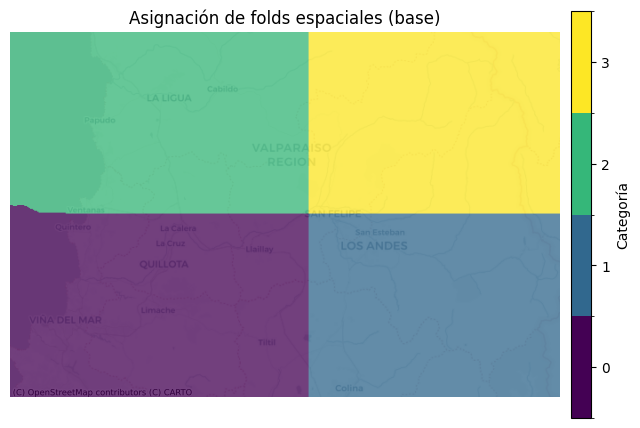

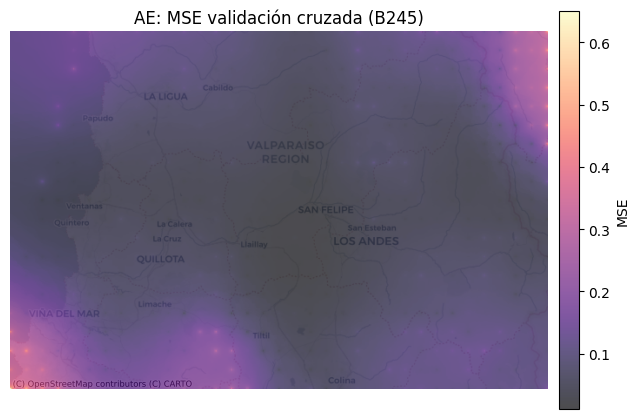

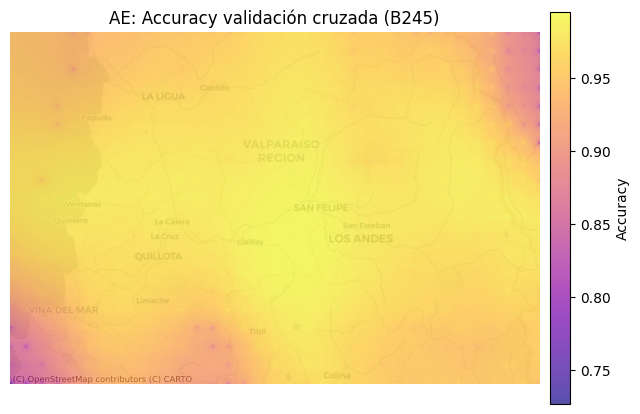

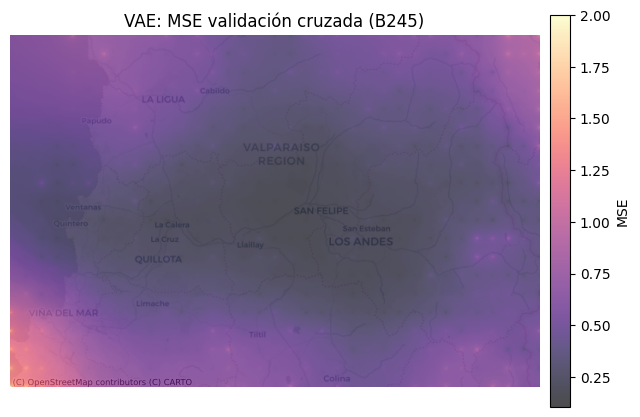

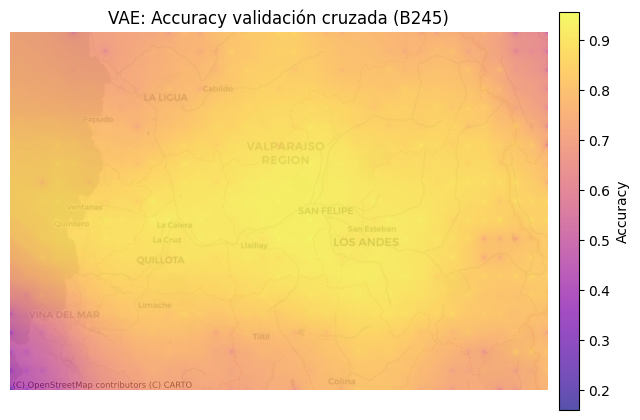

In [97]:

plot_spatial_categories(
    fold_ids_base,
    title="Asignación de folds espaciales (base)",
    cmap="viridis",
    s=26,
 )
for model_key in MODEL_ORDER:
    errors_b245 = CV_SAMPLE_ERRORS[model_key][get_scenario_slice("B245")]
    plot_spatial_scalar(
        errors_b245,
        title=f"{model_key}: MSE validación cruzada (B245)",
        cmap="magma",
        colorbar_label="MSE",
    )
    accuracy_b245 = np.maximum(0.0, 1.0 - errors_b245 / BASE_VARIANCE)
    plot_spatial_scalar(
        accuracy_b245,
        title=f"{model_key}: Accuracy validación cruzada (B245)",
        cmap="plasma",
        colorbar_label="Accuracy",
    )

In [ ]:
summary_tables = {
    "Reconstrucción (validación)": recon_df,
    "Clustering base": clustering_df,
    "Ablaciones": abl_df,
    "Cross-validation": cv_combined_df,
}

for name, df in summary_tables.items():
    print(f"\n{name}:")
    print(df)

if not abl_df.empty:
    print("\nPromedios de ablaciones por modelo:")
    print(abl_df.groupby("model")[["silhouette", "davies_bouldin", "val_mse"]].mean())

if not cv_combined_df.empty:
    print("\nCross-validation (estadísticos por modelo):")
    print(cv_combined_df.groupby("model")["val_mse"].agg(["mean", "std"]))



Reconstrucción (validación):
  model  latent_dim   val_mse    val_r2  epochs_trained  best_epoch  \
0    AE           8  0.020973  0.986164             279         248   
1   VAE           8  0.194113  0.868366              48          17   

   early_stop  val_elbo  val_recon_component  val_kl_component  
0        True       NaN                  NaN               NaN  
1        True  0.364658             0.194373          0.697891  

Clustering base:
  model  kmeans_k  kmeans_silhouette  kmeans_davies_bouldin  kmeans_inertia  \
0    AE         6           0.276742               1.380126    14817.236328   
1   VAE         6           0.360093               1.015467     3283.002686   

   dbscan_silhouette  dbscan_davies_bouldin  dbscan_clusters  
0            0.41886               0.825451               21  
1                NaN                    NaN                3  

Ablaciones:
             ablacion model  latent_dim  k_used  silhouette  davies_bouldin  \
0         no_extremos   

In [99]:

mse_ae_b = SPATIAL_RECON_ERRORS.get("AE")
mse_vae_b = SPATIAL_RECON_ERRORS.get("VAE")

if mse_ae_b is None or mse_vae_b is None:
    raise ValueError("Ejecuta la celda de 'SPATIAL_RECON_ERRORS' antes de calcular el índice R.")

zB245_ae = LATENTS["AE"]["B245"]
z_245_ae = LATENTS["AE"]["T245"]
z_370_ae = LATENTS["AE"]["T370"]
z_585_ae = LATENTS["AE"]["T585"]

zB245_vae = LATENTS["VAE"]["B245"]
z_245_vae = LATENTS["VAE"]["T245"]
z_370_vae = LATENTS["VAE"]["T370"]
z_585_vae = LATENTS["VAE"]["T585"]

In [100]:
# === Índice compuesto de resiliencia (R) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Funciones auxiliares ---
def robust_norm(x, pmin=5, pmax=95, eps=1e-9):
    lo, hi = np.percentile(x, pmin), np.percentile(x, pmax)
    return np.clip((x - lo) / (hi - lo + eps), 0, 1)

def composite_R(mse_n, shift_n, a=1.0, b=1.0):
    return np.power(1 - mse_n, a) * np.power(1 - shift_n, b)

# --- Cálculo de R para AE y VAE ---
# (asegúrate de tener definidos mse_ae_b, mse_vae_b, zB245_ae, z_245_ae, z_370_ae, etc.)

def latent_shift(z_base, z_target):
    return np.linalg.norm(z_target - z_base, axis=1)

# Normalización de errores y desplazamientos
mse_ae_n = robust_norm(mse_ae_b)
mse_vae_n = robust_norm(mse_vae_b)

d245_ae_n = robust_norm(latent_shift(zB245_ae, z_245_ae))
d370_ae_n = robust_norm(latent_shift(zB245_ae, z_370_ae))
d585_ae_n = robust_norm(latent_shift(zB245_ae, z_585_ae))

d245_vae_n = robust_norm(latent_shift(zB245_vae, z_245_vae))
d370_vae_n = robust_norm(latent_shift(zB245_vae, z_370_vae))
d585_vae_n = robust_norm(latent_shift(zB245_vae, z_585_vae))

# Índice de resiliencia compuesto
R_ae_245 = composite_R(mse_ae_n, d245_ae_n)
R_ae_370 = composite_R(mse_ae_n, d370_ae_n)
R_ae_585 = composite_R(mse_ae_n, d585_ae_n)

R_vae_245 = composite_R(mse_vae_n, d245_vae_n)
R_vae_370 = composite_R(mse_vae_n, d370_vae_n)
R_vae_585 = composite_R(mse_vae_n, d585_vae_n)

# --- Resumen estadístico ---
df_R = pd.DataFrame({
    "modelo": ["AE","AE","AE","VAE","VAE","VAE"],
    "escenario": ["245","370","585","245","370","585"],
    "R_mean": [R_ae_245.mean(), R_ae_370.mean(), R_ae_585.mean(),
               R_vae_245.mean(), R_vae_370.mean(), R_vae_585.mean()],
    "R_std": [R_ae_245.std(), R_ae_370.std(), R_ae_585.std(),
              R_vae_245.std(), R_vae_370.std(), R_vae_585.std()],
})
display(df_R.round(4))


modelo escenario  R_mean   R_std
0     AE       245  0.3770  0.2462
1     AE       370  0.3206  0.2410
2     AE       585  0.2471  0.2188
3    VAE       245  0.3426  0.2500
4    VAE       370  0.3704  0.2552
5    VAE       585  0.2868  0.2865

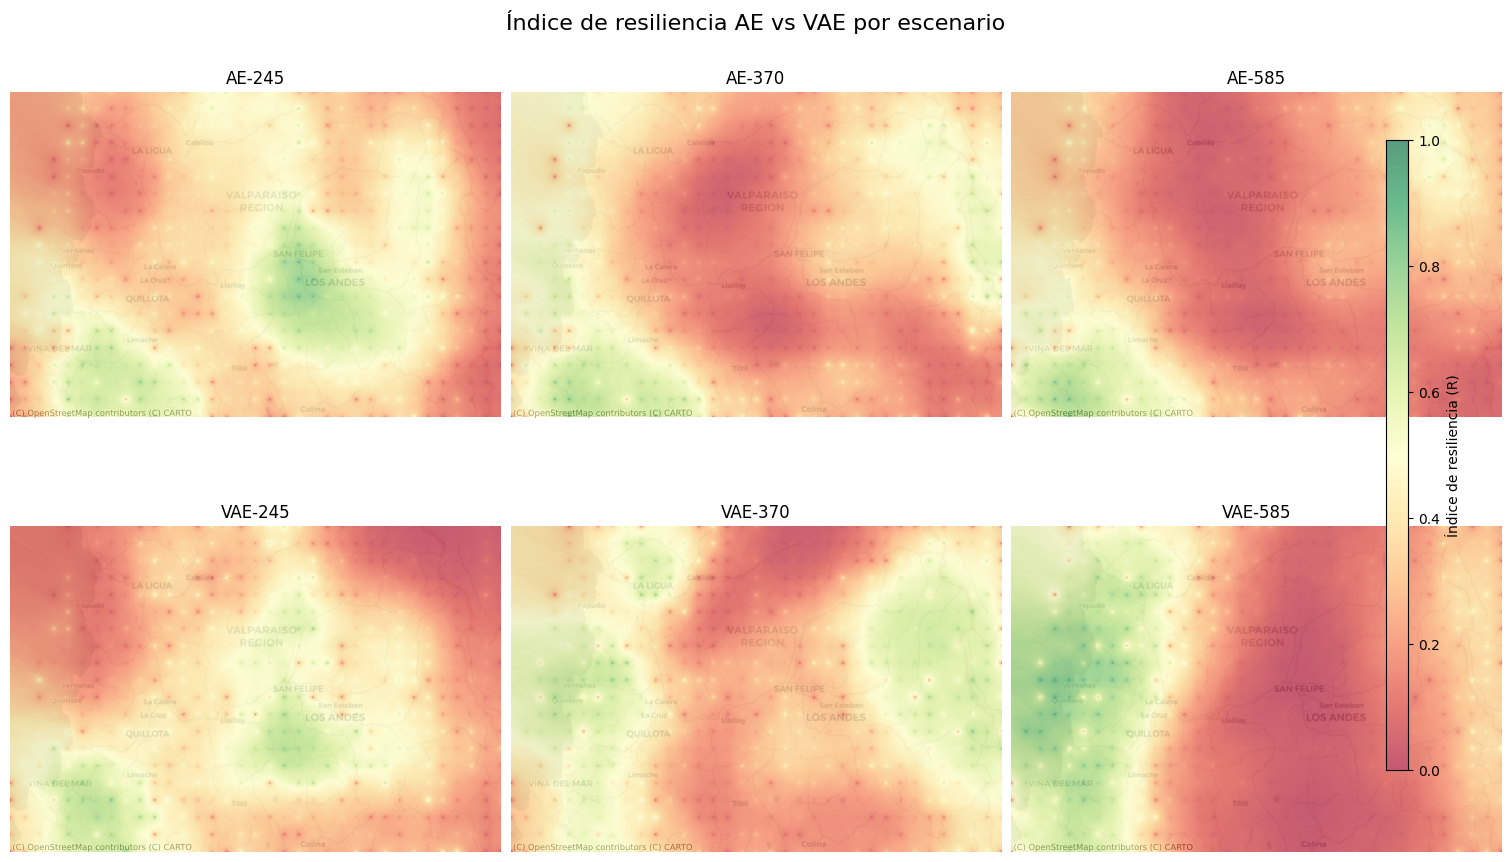

In [103]:
ae_maps = {
    "AE-245": R_ae_245,
    "AE-370": R_ae_370,
    "AE-585": R_ae_585,
}
vae_maps = {
    "VAE-245": R_vae_245,
    "VAE-370": R_vae_370,
    "VAE-585": R_vae_585,
}
all_maps = {**ae_maps, **vae_maps}

fig, axes = plt.subplots(2, 3, figsize=(15, 9), constrained_layout=True)
axes = axes.flatten()

shared_vmin, shared_vmax = 0.0, 1.0
for ax, (title, values) in zip(axes, all_maps.items()):
    xs, ys = _get_mercator_coords()
    grid_res = _infer_grid_resolution(len(values))
    grid_x = np.linspace(xs.min(), xs.max(), grid_res)
    grid_y = np.linspace(ys.min(), ys.max(), grid_res)
    GX, GY = np.meshgrid(grid_x, grid_y)
    coords = np.column_stack([xs, ys])
    grid_points = np.column_stack([GX.ravel(), GY.ravel()])
    n_neighbors = max(3, min(len(values), int(np.sqrt(len(values)) * 1.5)))
    reg = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance")
    reg.fit(coords, values)
    GZ = reg.predict(grid_points).reshape(GX.shape)
    extent = (grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max())
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    try:
        import contextily as ctx
        ctx.add_basemap(
            ax,
            source=ctx.providers.CartoDB.Positron,
            crs="EPSG:3857",
            alpha=1.0,
            attribution_size=6,
        )
    except Exception as basemap_err:
        ax.text(
            0.02,
            0.02,
            f"Basemap no disponible: {basemap_err}",
            transform=ax.transAxes,
            fontsize=8,
            color="red",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"),
        )
    heat = ax.imshow(
        GZ,
        extent=extent,
        origin="lower",
        cmap="RdYlGn",
        vmin=shared_vmin,
        vmax=shared_vmax,
        alpha=0.65,
        zorder=3,
    )
    ax.set_axis_off()
    ax.set_title(title)

for ax in axes[len(all_maps):]:
    ax.remove()

cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(heat, cax=cax, label="Índice de resiliencia (R)")
fig.suptitle("Índice de resiliencia AE vs VAE por escenario", fontsize=16)
plt.show()